In [6]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# changed model


### regression

In [10]:
import numpy as np
dataset_path = "dataset/dataset_0725"

X_train = np.load(f'{dataset_path}/X_train.npy')
y_train = np.load(f'{dataset_path}/y_train.npy').astype(float).flatten()
X_val = np.load(f'{dataset_path}/X_val.npy')
y_val = np.load(f'{dataset_path}/y_val.npy').astype(float).flatten()
X_test = np.load(f'{dataset_path}/X_test.npy')
y_test = np.load(f'{dataset_path}/y_test.npy').astype(float).flatten()

y_train = np.where(y_train < 4, 0, np.where(y_train <= 7, 1, 2))
y_val = np.where(y_val < 4, 0, np.where(y_val <= 7, 1, 2))
y_test = np.where(y_test < 4, 0, np.where(y_test <= 7, 1, 2))




In [11]:
y_train.shape

(5821,)

### MLP


Epoch [1/200], Loss: 0.6245, Accuracy: 0.7609
Validation Loss: 0.4735, Validation Accuracy: 0.8159
Epoch [2/200], Loss: 0.4127, Accuracy: 0.8383
Validation Loss: 0.3744, Validation Accuracy: 0.8489
Epoch [3/200], Loss: 0.3446, Accuracy: 0.8650
Validation Loss: 0.3320, Validation Accuracy: 0.8777
Epoch [4/200], Loss: 0.3078, Accuracy: 0.8784
Validation Loss: 0.2994, Validation Accuracy: 0.8887
Epoch [5/200], Loss: 0.2829, Accuracy: 0.8911
Validation Loss: 0.2810, Validation Accuracy: 0.8942
Epoch [6/200], Loss: 0.2670, Accuracy: 0.8974
Validation Loss: 0.2662, Validation Accuracy: 0.8970
Epoch [7/200], Loss: 0.2530, Accuracy: 0.9033
Validation Loss: 0.2586, Validation Accuracy: 0.9135
Epoch [8/200], Loss: 0.2467, Accuracy: 0.9028
Validation Loss: 0.2478, Validation Accuracy: 0.8984
Epoch [9/200], Loss: 0.2380, Accuracy: 0.9074
Validation Loss: 0.2497, Validation Accuracy: 0.9080
Epoch [10/200], Loss: 0.2326, Accuracy: 0.9077
Validation Loss: 0.2601, Validation Accuracy: 0.9025
Epoch [11

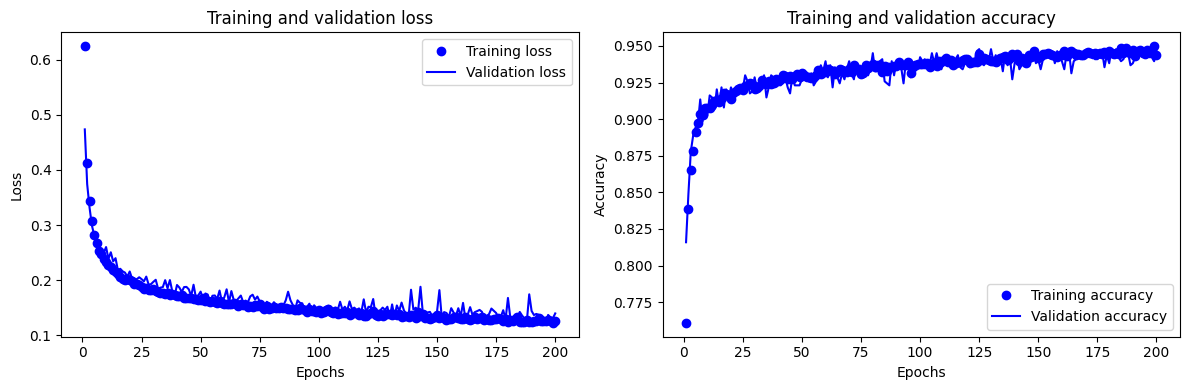

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# 假设 X_train, y_train, X_val, y_val, X_test, y_test 数据已经存在

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 数据归一化
mean = X_train_tensor.mean(dim=0, keepdim=True)
std = X_train_tensor.std(dim=0, keepdim=True)
X_train_tensor = (X_train_tensor - mean) / std
X_val_tensor = (X_val_tensor - mean) / std
X_test_tensor = (X_test_tensor - mean) / std

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义模型
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleMLP(input_dim=12, num_classes=3)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 记录损失和准确率
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 训练模型
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# 测试模型
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# 绘制损失和准确率图
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# 计算最好的训练准确率和验证准确率
best_train_accuracy = max(train_accuracies)
best_val_accuracy = max(val_accuracies)

# 找到最佳训练和验证准确率对应的epoch
best_train_epoch = train_accuracies.index(best_train_accuracy) + 1
best_val_epoch = val_accuracies.index(best_val_accuracy) + 1

print(f'Best Training Accuracy: {best_train_accuracy:.4f} at epoch {best_train_epoch}')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_val_epoch}')


Best Training Accuracy: 0.9498 at epoch 199
Best Validation Accuracy: 0.9478 at epoch 125
